In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### Load Data:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_train = pd.read_csv('/content/drive/My Drive/PM_train.csv')
df_train.head()

id  cycle  setting1  setting2  ...      sd21  ttf  label_bnc  label_mcc
0   1      1   -0.0007   -0.0004  ...  0.000000  191          0          0
1   1      2    0.0019   -0.0003  ...  0.003253  190          0          0
2   1      3   -0.0043    0.0003  ...  0.044573  189          0          0
3   1      4    0.0007    0.0000  ...  0.037977  188          0          0
4   1      5   -0.0019   -0.0002  ...  0.033498  187          0          0

[5 rows x 71 columns]

In [0]:
df_test = pd.read_csv('/content/drive/My Drive/PM_test.csv')
df_test.head()

id  cycle  setting1  setting2  ...      sd21  ttf  label_bnc  label_mcc
0   1     31   -0.0006    0.0004  ...  0.025037  112          0          0
1   2     49    0.0018   -0.0001  ...  0.027820   98          0          0
2   3    126   -0.0016    0.0004  ...  0.018966   69          0          0
3   4    106    0.0012    0.0004  ...  0.021106   82          0          0
4   5     98   -0.0013   -0.0004  ...  0.101100   91          0          0

[5 rows x 71 columns]

- 원래 특성 및 추가된 특성 사용하기

In [0]:
# original features
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# original + extracted fetures
features_extr = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

y_train = df_train['label_bnc']
y_test = df_test['label_bnc']


## 이진 분류

In [0]:
def bin_classify(model, clf, features, params=None, score=None):
    
    """ 그리드 탐색 수행
    
    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        features (list): The set of input features names
        params (dict): Grid Search parameters
        score (str): Grid Search score
        
    Returns:
        Tuned Clssifier object
        dataframe of model predictions and scores
    
    """
    
    
    X_train = df_train[features]
    X_test = df_test[features] 
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions
    

In [0]:
def bin_class_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """Calculate main binary classifcation metrics, plot AUC ROC and Precision-Recall curves.
    
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics in single dataframe
        dataframe: ROC thresholds
        dataframe: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
        plot: Precision-Recall threshold; also show the number of engines predicted for maintenace per period (queue).
        plot: TPR-FPR threshold
        
    """
      
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model]  


    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    
    roc_auc = metrics.auc(fpr, tpr)

    engines_roc = []  
    for thr in thresh_roc:  
        engines_roc.append((y_score >= thr).mean())

    engines_roc = np.array(engines_roc)

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'Que' : engines_roc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    #calculate other classification metrics: TP, FP, TN, FN, TNR, FNR
    #from ground truth file, positive class = 25 => TP + FN = 25
    #from ground truth file, negative class = 75 => TN + FP = 75
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1 - df_roc_thresh.FPR))).astype(int)
    
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FP'])
    
    df_roc_thresh['Model'] = model

    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)
    thresh_prc = np.append(thresh_prc,1)

    engines_prc = []  
    for thr in thresh_prc:  
        engines_prc.append((y_score >= thr).mean())

    engines_prc = np.array(engines_prc)

    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Que' : engines_prc
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)

        print('\nROC Thresholds:\n')
        print(df_roc_thresh[['Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR','FNR', 'Que']])

        print('\nPrecision-Recall Thresholds:\n')
        print(df_prc_thresh[['Threshold', 'Precision', 'Recall', 'Que']])

    if plot_out:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(10,10)

        ax1.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f'% roc_auc)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')

        ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')

        ax3.plot(thresh_roc, fpr, color='red', lw=2, label='FPR')  
        ax3.plot(thresh_roc, tpr, color='green',label='TPR') 
        ax3.plot(thresh_roc, engines_roc, color='blue',label='Engines') 
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel('Threshold')  
        ax3.set_ylabel('%')
        ax3.legend(loc='upper right', fontsize='small')

        ax4.plot(thresh_prc, precision, color='red', lw=2, label='Precision')  
        ax4.plot(thresh_prc, recall, color='green',label='Recall') 
        ax4.plot(thresh_prc, engines_prc, color='blue',label='Engines') 
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('Threshold')  
        ax4.set_ylabel('%')
        ax4.legend(loc='lower left', fontsize='small')

    return  df_metrics, df_roc_thresh, df_prc_thresh


## 알고리즘 비교

## 모델 A, B

- B: 추가 특성을 사용하가 전의(before) 원래 특성만 사용하는 모델
- A: 추가 특성을 사용한 이후(after)의 모델 적용

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Best Parameters:
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------------------------------
Logistic Regression B 

Confusion Matrix:
[[75  0]
 [ 9 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        75
           1       1.00      0.64      0.78        25

    accuracy                           0.91       100
   macro avg       0.95      0.82      0.86       100
weighted avg       0.92      0.91      0.90       100


Metrics:
           Logistic Regression B
Accuracy                0.910000
Precision               1.000000
Recall                  0.640000
F1 Score                0.780488
ROC AUC   

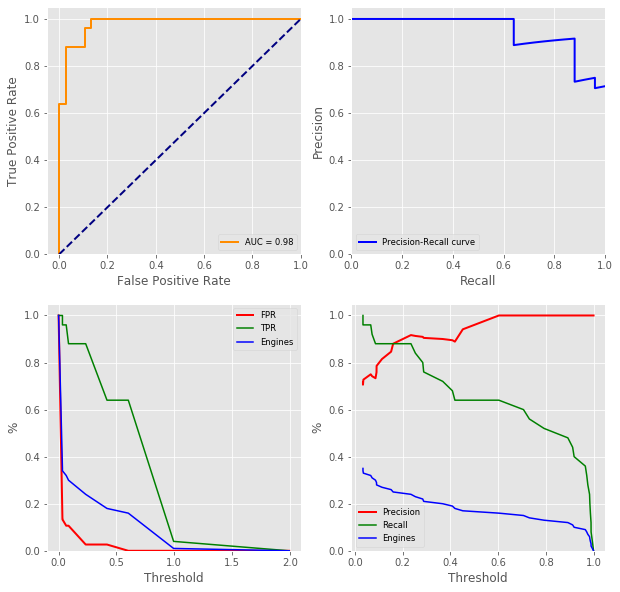

In [0]:
model = 'Logistic Regression B'
clf_lgrb = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_lgrb, pred_lgrb = bin_classify(model, clf_lgrb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_lgrb)

metrics_lgrb, roc_lgrb, prc_lgrb = bin_class_metrics(model, y_test, pred_lgrb.y_pred, pred_lgrb.y_score, print_out=True, plot_out=True)

- 위에서 Engines은 점검이 필요한 엔진의 수를 나타낸다. (maintenance capacity)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)



Best Parameters:
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------------------------------
Logistic Regression A 

Confusion Matrix:
[[75  0]
 [ 8 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        75
           1       1.00      0.68      0.81        25

    accuracy                           0.92       100
   macro avg       0.95      0.84      0.88       100
weighted avg       0.93      0.92      0.91       100


Metrics:
           Logistic Regression A
Accuracy                0.920000
Precision               1.000000
Recall                  0.680000
F1 Score                0.809524
ROC AUC   

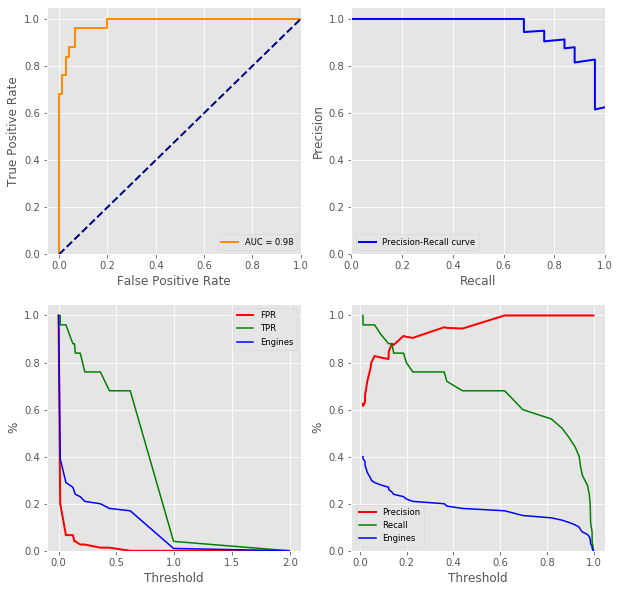

In [0]:
model = 'Logistic Regression A'
clf_lgra = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_lgra, pred_lgra = bin_classify(model, clf_lgra, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_lgra)

metrics_lgra, roc_lgra, prc_lgra = bin_class_metrics(model, y_test, pred_lgra.y_pred, pred_lgra.y_score, print_out=True, plot_out=True)

In [0]:
metrics_lgr = pd.concat([metrics_lgrb, metrics_lgra], axis=1)
metrics_lgr

Logistic Regression B  Logistic Regression A
Accuracy                0.910000               0.920000
Precision               1.000000               1.000000
Recall                  0.640000               0.680000
F1 Score                0.780488               0.809524
ROC AUC                 0.979733               0.981867


Best Parameters:
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')
-----------------------------------------------------------
Decision Tree B 

Confusion Matrix:
[[74  1]
 [11 14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       0.93      0.56      0.70        25

    accuracy                           0.88       100
   macro avg       0.90      0.77      0.81       100
weighted avg       0.89      0.88      0.87       100


Metrics:
           Decision Tree B
Accuracy          0.880000
Precision         0.933333
Recall            0.

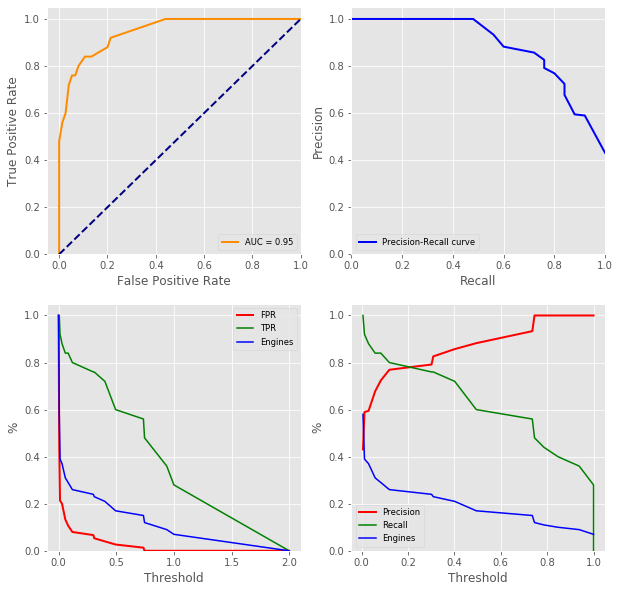

In [0]:
model = 'Decision Tree B'
clf_dtrb = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [2, 3, 4, 5, 6], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtrb, pred_dtrb = bin_classify(model, clf_dtrb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_dtrb)

metrics_dtrb, roc_dtrb, prc_dtrb = bin_class_metrics(model, y_test, pred_dtrb.y_pred, pred_dtrb.y_score, print_out=True, plot_out=True)


Best Parameters:
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=123, splitter='best')
-----------------------------------------------------------
Decision Tree A 

Confusion Matrix:
[[74  1]
 [ 7 18]]

Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.99      0.95        75
          1       0.95      0.72      0.82        25

avg / total       0.92      0.92      0.92       100


Metrics:
           Decision Tree A
ROC AUC           0.962933
Recall            0.720000
Accuracy          0.920000
Precision         0.947368
F1 Score          0.818182

ROC Thresholds:

   Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0   1.000000  10  15  75   0  0.40  0.000000  1.000000 

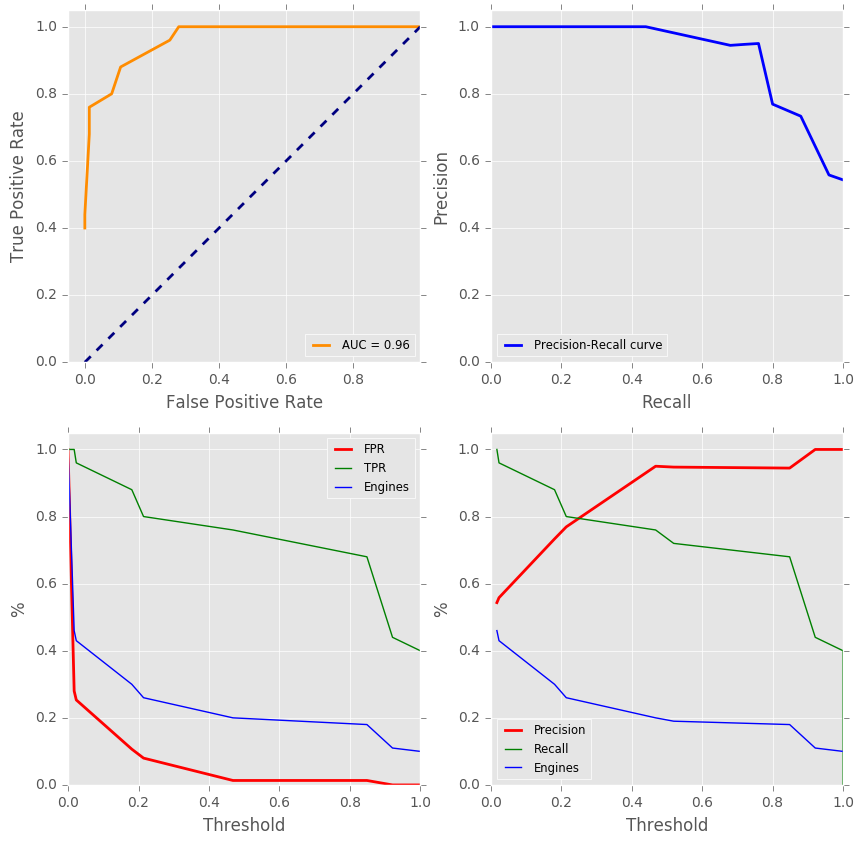

In [0]:
model = 'Decision Tree A'
clf_dtra = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [3, 4, 5, 6, 7], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtra, pred_dtra = bin_classify(model, clf_dtra, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_dtra)

metrics_dtra, roc_dtra, prc_dtra = bin_class_metrics(model, y_test, pred_dtra.y_pred, pred_dtra.y_score, print_out=True, plot_out=True)


In [0]:
metrics_dtr = pd.concat([metrics_dtrb, metrics_dtra], axis=1)
metrics_dtr

Decision Tree B  Decision Tree A
ROC AUC           0.945067         0.962933
Recall            0.560000         0.720000
Accuracy          0.880000         0.920000
Precision         0.933333         0.947368
F1 Score          0.700000         0.818182


Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest B 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.99      0.94        75
          1       0.94      0.68      0.79        25

avg / total       0.91      0.91      0.90       100


Metrics:
           Random Forest B
ROC AUC           0.980267
Recall            0.680000
Accuracy          0.910000
Precision         0.944444
F1 Score          0.790698

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR

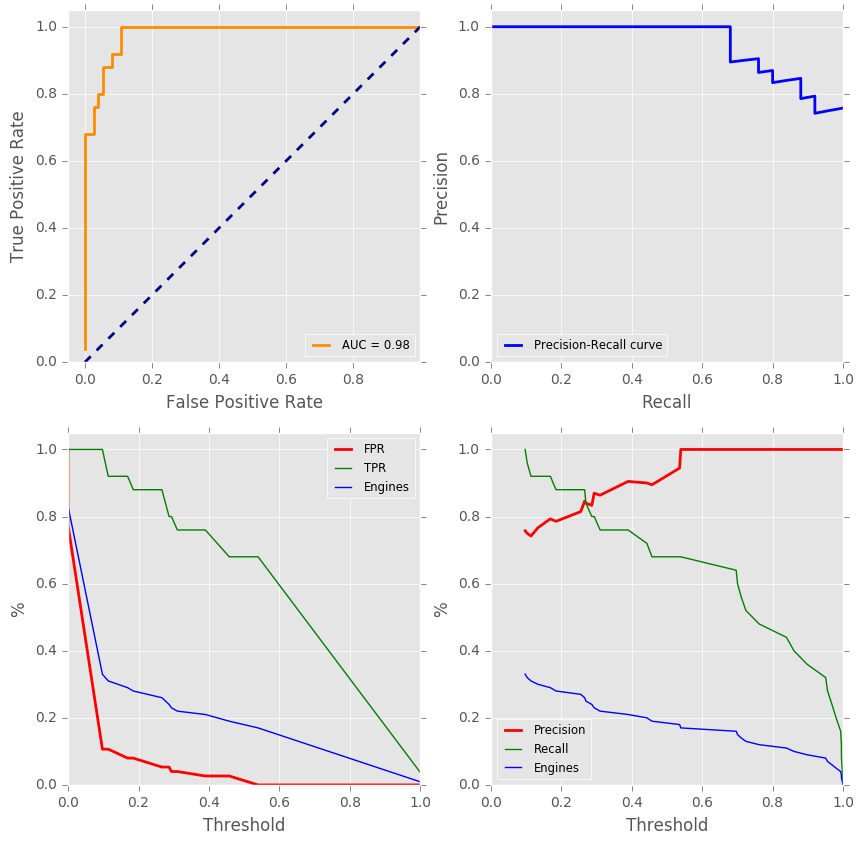

In [0]:
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_rfcb, pred_rfcb = bin_classify(model, clf_rfcb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, roc_rfcb, prc_rfcb = bin_class_metrics(model, y_test, pred_rfcb.y_pred, pred_rfcb.y_score, print_out=True, plot_out=True)


Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest A 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.99      0.94        75
          1       0.94      0.68      0.79        25

avg / total       0.91      0.91      0.90       100


Metrics:
           Random Forest A
ROC AUC           0.982400
Recall            0.680000
Accuracy          0.910000
Precision         0.944444
F1 Score          0.790698

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR

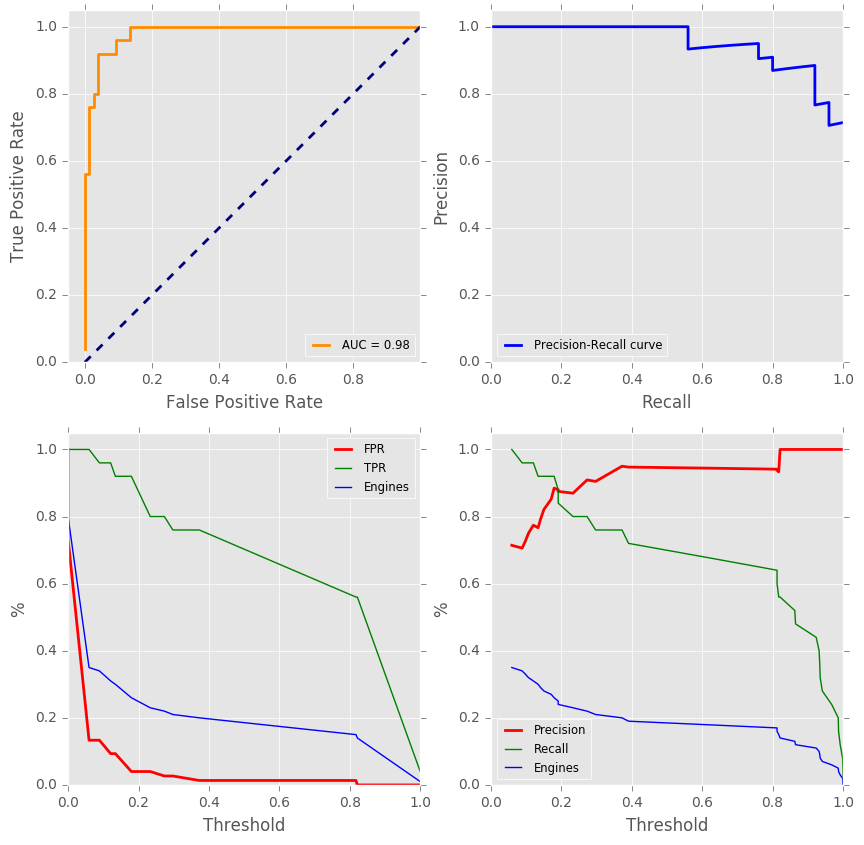

In [0]:
model = 'Random Forest A'
clf_rfca = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_rfca, pred_rfca = bin_classify(model, clf_rfca, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_rfca)

metrics_rfca, roc_rfca, prc_rfca = bin_class_metrics(model, y_test, pred_rfca.y_pred, pred_rfca.y_score, print_out=True, plot_out=True)

In [0]:
metrics_rfc = pd.concat([metrics_rfcb, metrics_rfca], axis=1)
metrics_rfc

Random Forest B  Random Forest A
ROC AUC           0.980267         0.982400
Recall            0.680000         0.680000
Accuracy          0.910000         0.910000
Precision         0.944444         0.944444
F1 Score          0.790698         0.790698


Best Parameters:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)
-----------------------------------------------------------
SVC B 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.99      0.94        75
          1       0.94      0.68      0.79        25

avg / total       0.91      0.91      0.90       100


Metrics:
              SVC B
ROC AUC    0.891733
Recall     0.680000
Accuracy   0.910000
Precision  0.944444
F1 Score   0.790698

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.405108   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
1    0.730778  13  12  75   0  0.52  0.000000  1.000000  0.862069  0.13
2    0.633767  13  12  74   1  0.52  0.013333  0.9

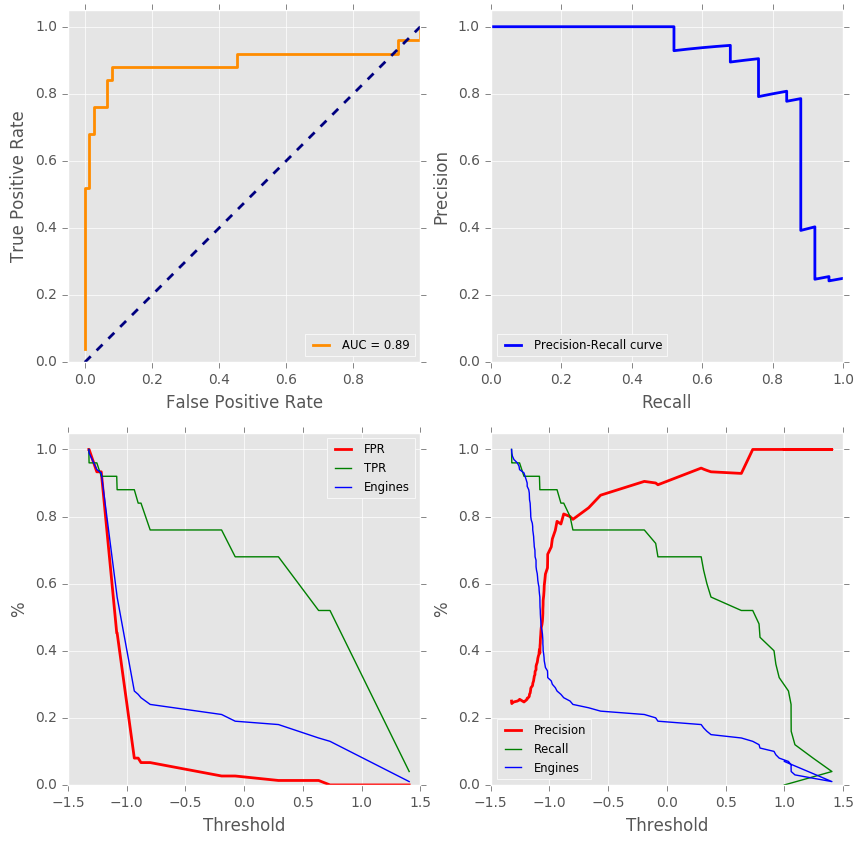

In [0]:
model = 'SVC B'
clf_svcb = SVC(kernel='rbf', random_state=123)
gs_params = {'C': [1.0]}
gs_score = 'roc_auc'

clf_svcb, pred_svcb = bin_classify(model, clf_svcb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_svcb)

metrics_svcb, roc_svcb, prc_svcb = bin_class_metrics(model, y_test, pred_svcb.y_pred, pred_svcb.y_score, print_out=True, plot_out=True)


Best Parameters:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)
-----------------------------------------------------------
SVC A 

Confusion Matrix:
[[74  1]
 [ 7 18]]

Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.99      0.95        75
          1       0.95      0.72      0.82        25

avg / total       0.92      0.92      0.92       100


Metrics:
              SVC A
ROC AUC    0.930133
Recall     0.720000
Accuracy   0.920000
Precision  0.947368
F1 Score   0.818182

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.591611   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
1    0.170041  17   8  75   0  0.68  0.000000  1.000000  0.903614  0.17
2    0.103133  17   8  74   1  0.68  0.013333  0.9

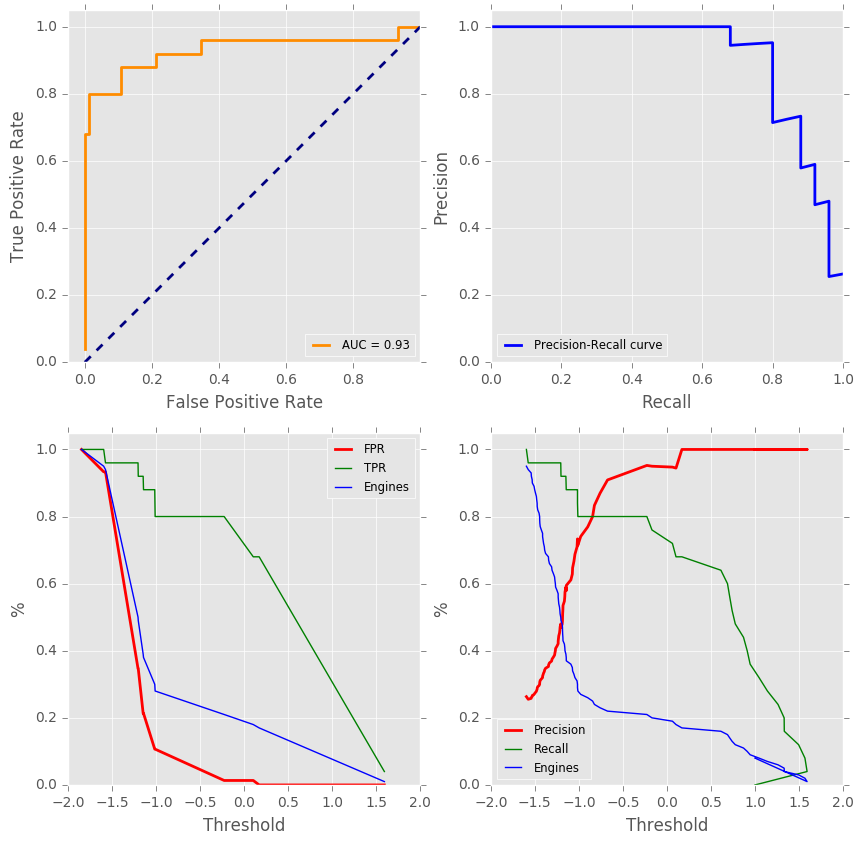

In [0]:
model = 'SVC A'
clf_svca = SVC(kernel='rbf', random_state=123)
gs_params = {'C': [1.0]}
gs_score = 'roc_auc'

clf_svca, pred_svca = bin_classify(model, clf_svca, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_svca)

metrics_svca, roc_svca, prc_svca = bin_class_metrics(model, y_test, pred_svca.y_pred, pred_svca.y_score, print_out=True, plot_out=True)

In [0]:
# Compare SVC Before and After FE
metrics_svc = pd.concat([metrics_svcb, metrics_svca], axis=1)
metrics_svc.sort_index()

SVC B     SVC A
Accuracy   0.910000  0.920000
F1 Score   0.790698  0.818182
Precision  0.944444  0.947368
ROC AUC    0.891733  0.930133
Recall     0.680000  0.720000


Best Parameters:
 LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
     verbose=0)
-----------------------------------------------------------
SVC Linear B 

Confusion Matrix:
[[75  0]
 [15 10]]

Classification Report:
             precision    recall  f1-score   support

          0       0.83      1.00      0.91        75
          1       1.00      0.40      0.57        25

avg / total       0.88      0.85      0.82       100


Metrics:
           SVC Linear B
ROC AUC        0.971733
Recall         0.400000
Accuracy       0.850000
Precision      1.000000
F1 Score       0.571429

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    0.833338   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
1   -0.026667  11  14  75   0  0.44  0.000000  1.000000  0.842697  0.11
2   -0.049135  11  14  74   

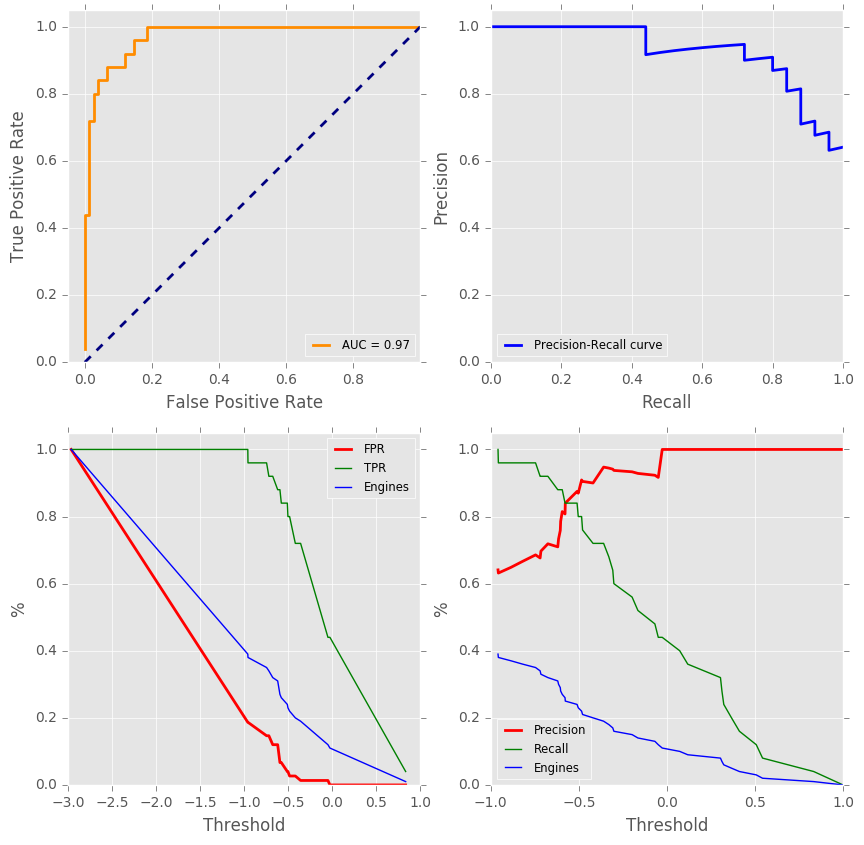

In [0]:
model = 'SVC Linear B'
clf_svlb = LinearSVC(random_state=123)
gs_params = {'C': [.01 ,.1 ,1.0]}
gs_score = 'roc_auc'

clf_svlb, pred_svlb = bin_classify(model, clf_svlb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_svlb)

metrics_svlb, roc_svlb, prc_svlb = bin_class_metrics(model, y_test, pred_svlb.y_pred, pred_svlb.y_score, print_out=True, plot_out=True)


Best Parameters:
 LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
     verbose=0)
-----------------------------------------------------------
SVC Linear A 

Confusion Matrix:
[[42 33]
 [ 0 25]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.56      0.72        75
          1       0.43      1.00      0.60        25

avg / total       0.86      0.67      0.69       100


Metrics:
           SVC Linear A
ROC AUC        0.979733
Recall         1.000000
Accuracy       0.670000
Precision      0.431034
F1 Score       0.602410

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.915683   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
1    1.226355  13  12  75   0  0.52  0.000000  1.000000  0.862069  0.13
2    1.166580  13  12  74  

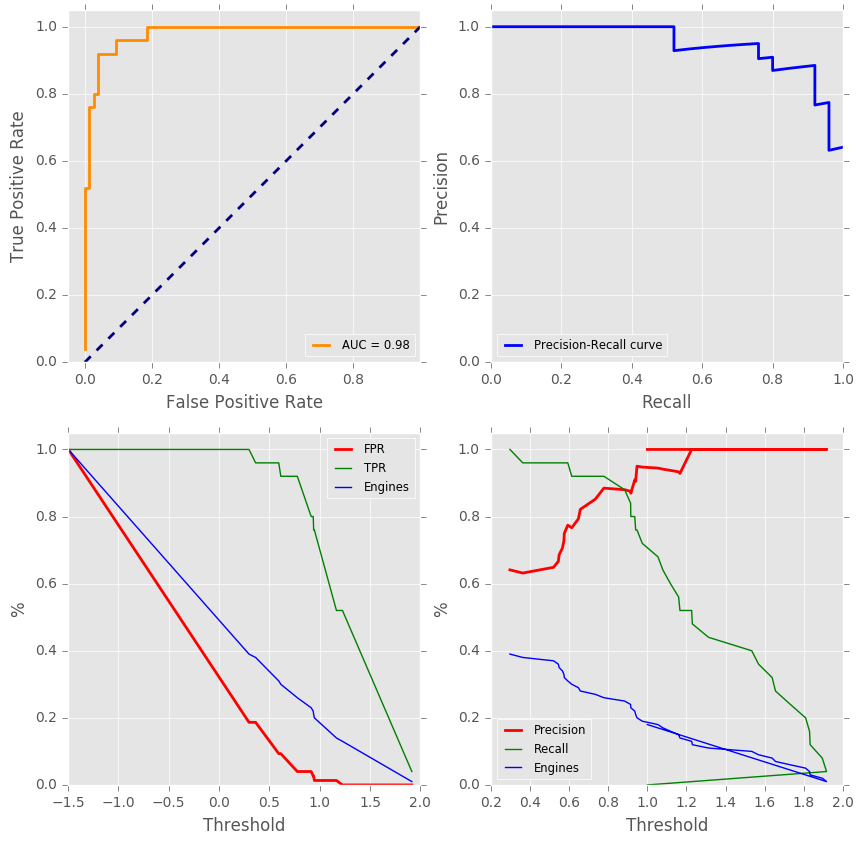

In [0]:
model = 'SVC Linear A'
clf_svla = LinearSVC(random_state=123)
gs_params = {'C': [.001, .01 ,.1 ]}
gs_score = 'roc_auc'

clf_svla, pred_svla = bin_classify(model, clf_svla, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_svla)

metrics_svla, roc_svla, prc_svla = bin_class_metrics(model, y_test, pred_svla.y_pred, pred_svla.y_score, print_out=True, plot_out=True)



In [0]:
# Compare Linear SVC Before and After FE
metrics_svl = pd.concat([metrics_svlb, metrics_svla], axis=1)
metrics_svl.sort_index()

SVC Linear B  SVC Linear A
Accuracy       0.850000      0.670000
F1 Score       0.571429      0.602410
Precision      1.000000      0.431034
ROC AUC        0.971733      0.979733
Recall         0.400000      1.000000


Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform')
-----------------------------------------------------------
KNN B 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.99      0.94        75
          1       0.94      0.68      0.79        25

avg / total       0.91      0.91      0.90       100


Metrics:
              KNN B
ROC AUC    0.935200
Recall     0.680000
Accuracy   0.910000
Precision  0.944444
F1 Score   0.790698

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.000000   5  20  75   0  0.20  0.000000  1.000000  0.789474  0.05
1    0.923077  10  15  75   0  0.40  0.000000  1.000000  0.833333  0.10
2    0.846154  12  13  75   0  0.48  0.000000  1.000000  0.852273  0.12
3    0.769231  14  10  74   1  0.56

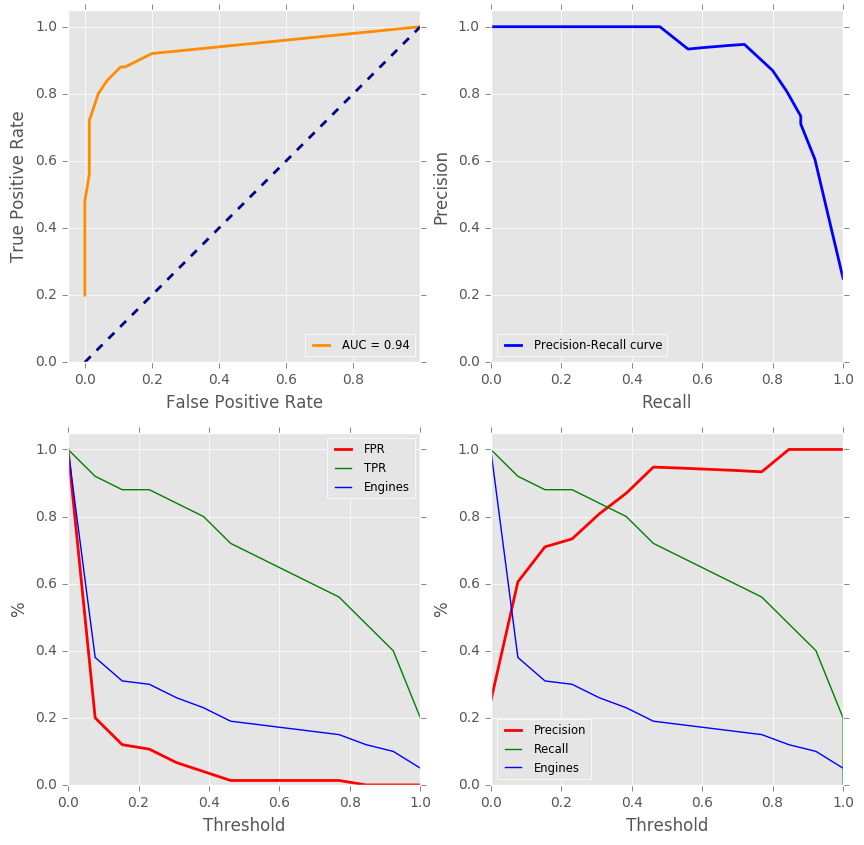

In [0]:
model = 'KNN B'
clf_knnb = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}
gs_score = 'roc_auc'

clf_knnb, pred_knnb = bin_classify(model, clf_knnb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_knnb)

metrics_knnb, roc_knnb, prc_knnb = bin_class_metrics(model, y_test, pred_knnb.y_pred, pred_knnb.y_score, print_out=True, plot_out=True)


Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform')
-----------------------------------------------------------
KNN A 

Confusion Matrix:
[[74  1]
 [ 7 18]]

Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.99      0.95        75
          1       0.95      0.72      0.82        25

avg / total       0.92      0.92      0.92       100


Metrics:
              KNN A
ROC AUC    0.963467
Recall     0.720000
Accuracy   0.920000
Precision  0.947368
F1 Score   0.818182

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.000000   8  17  75   0  0.32  0.000000  1.000000  0.815217  0.08
1    0.923077  12  13  75   0  0.48  0.000000  1.000000  0.852273  0.12
2    0.846154  14  10  75   0  0.56  0.000000  1.000000  0.882353  0.14
3    0.769231  15  10  75   0  0.60

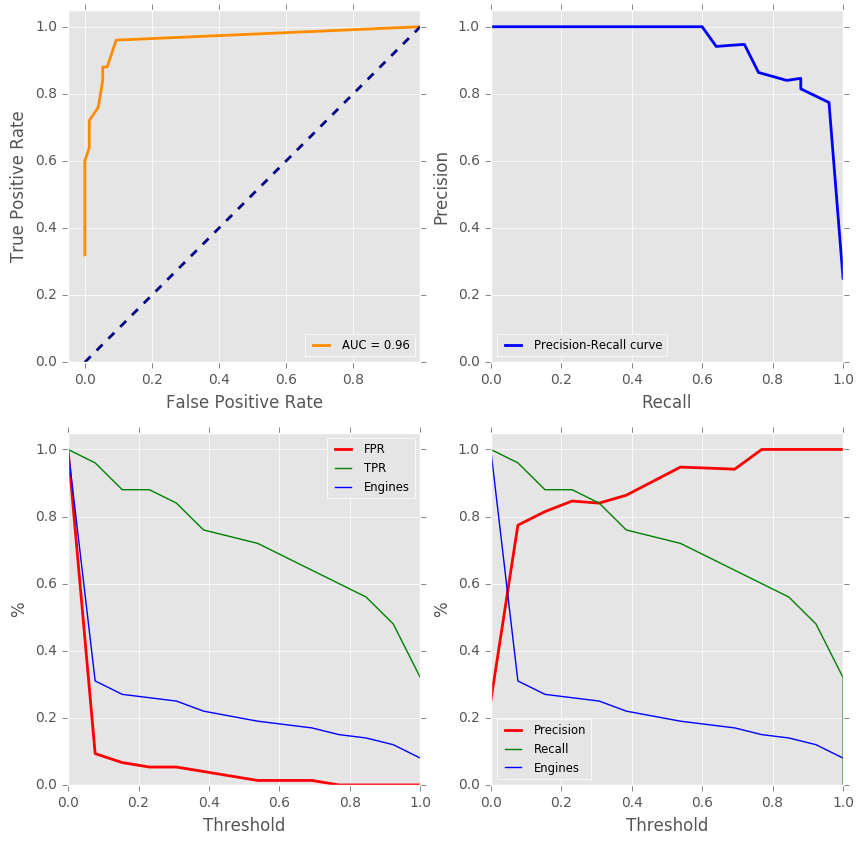

In [0]:
model = 'KNN A'
clf_knna = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [9 , 10, 11, 12, 13]}
gs_score = 'roc_auc'

clf_knna, pred_knna = bin_classify(model, clf_knna, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_knna)

metrics_knna, roc_knna, prc_knna = bin_class_metrics(model, y_test, pred_knna.y_pred, pred_knna.y_score, print_out=True, plot_out=True)

In [0]:
# Compare KNN Before and After FE
metrics_knn = pd.concat([metrics_knnb, metrics_knna], axis=1)
metrics_knn.sort_index()

KNN B     KNN A
Accuracy   0.910000  0.920000
F1 Score   0.790698  0.818182
Precision  0.944444  0.947368
ROC AUC    0.935200  0.963467
Recall     0.680000  0.720000


Best Parameters:
 GaussianNB(priors=None)
-----------------------------------------------------------
Gaussian NB B 

Confusion Matrix:
[[70  5]
 [ 1 24]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.93      0.96        75
          1       0.83      0.96      0.89        25

avg / total       0.95      0.94      0.94       100


Metrics:
           Gaussian NB B
ROC AUC         0.987733
Recall          0.960000
Accuracy        0.940000
Precision       0.827586
F1 Score        0.888889

ROC Thresholds:

       Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0   1.000000e+00   8  17  75   0  0.32  0.000000  1.000000  0.815217  0.08
1   1.000000e+00  17   8  75   0  0.68  0.000000  1.000000  0.903614  0.17
2   1.000000e+00  17   8  74   1  0.68  0.013333  0.986667  0.902439  0.18
3   9.999983e-01  18   7  74   1  0.72  0.013333  0.986667  0.913580  0.19
4   9.999972e-01  18   7  73   2  0.72  0.026667  0.

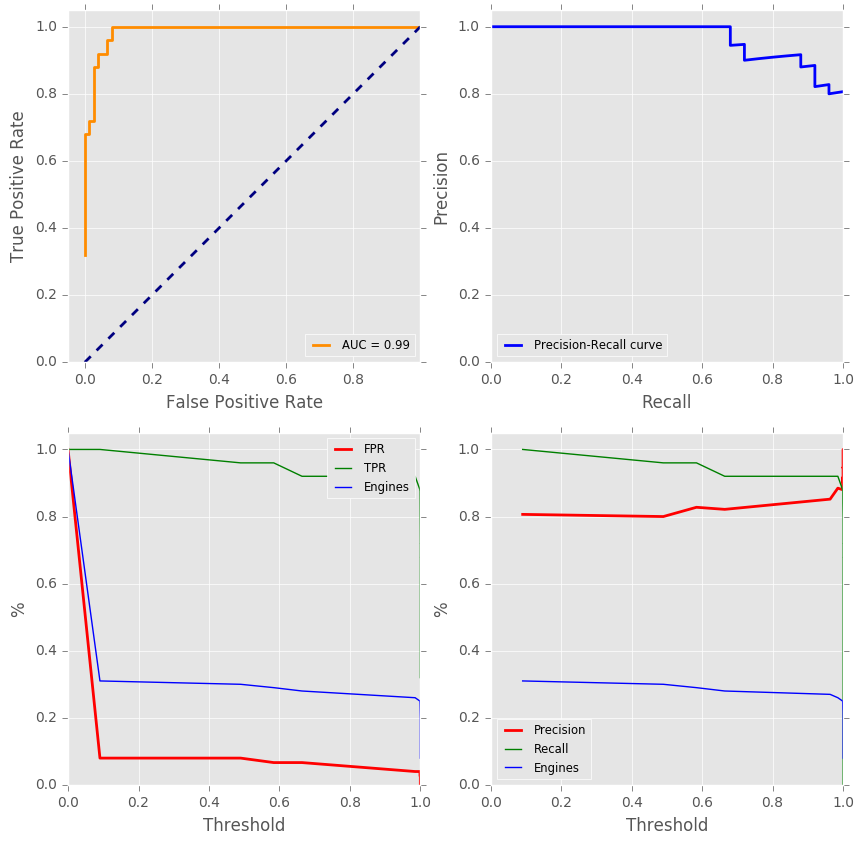

In [0]:
model = 'Gaussian NB B'
clf_gnbb = GaussianNB()
gs_params = {} 
gs_score = 'roc_auc'

clf_gnbb, pred_gnbb = bin_classify(model, clf_gnbb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_gnbb)

metrics_gnbb, roc_gnbb, prc_gnbb = bin_class_metrics(model, y_test, pred_gnbb.y_pred, pred_gnbb.y_score, print_out=True, plot_out=True)


Best Parameters:
 GaussianNB(priors=None)
-----------------------------------------------------------
Gaussian NB A 

Confusion Matrix:
[[70  5]
 [ 1 24]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.93      0.96        75
          1       0.83      0.96      0.89        25

avg / total       0.95      0.94      0.94       100


Metrics:
           Gaussian NB A
ROC AUC         0.980533
Recall          0.960000
Accuracy        0.940000
Precision       0.827586
F1 Score        0.888889

ROC Thresholds:

       Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0   2.000000e+00   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1   1.000000e+00  17   8  74   1  0.68  0.013333  0.986667  0.902439  0.18
2   1.000000e+00  20   5  74   1  0.80  0.013333  0.986667  0.936709  0.21
3   9.999630e-01  20   5  71   4  0.80  0.053333  0.946667  0.934211  0.24
4   9.697437e-01  24   1  71   4  0.96  0.053333  0.

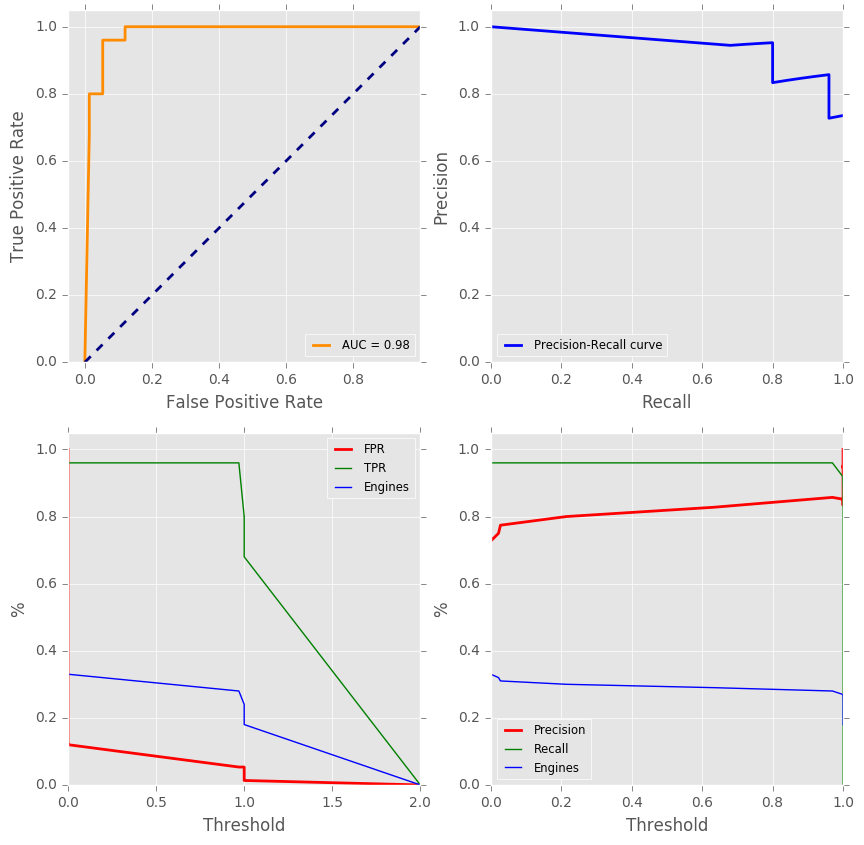

In [0]:
model = 'Gaussian NB A'
clf_gnba = GaussianNB()
gs_params = {} 
gs_score = 'roc_auc'

clf_gnba, pred_gnba = bin_classify(model, clf_gnba, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_gnba)

metrics_gnba, roc_gnba, prc_gnba = bin_class_metrics(model, y_test, pred_gnba.y_pred, pred_gnba.y_score, print_out=True, plot_out=True)


In [0]:
# Compare Naive Bayes Before and After FE
metrics_gnb = pd.concat([metrics_gnbb, metrics_gnba], axis=1)
metrics_gnb.sort_index()

Gaussian NB B  Gaussian NB A
Accuracy        0.940000       0.940000
F1 Score        0.888889       0.888889
Precision       0.827586       0.827586
ROC AUC         0.987733       0.980533
Recall          0.960000       0.960000

## 이진 분류 모델의 성능 비교

In [0]:
#compare all models
metrics_bn = pd.concat([metrics_lgr, metrics_dtr, metrics_rfc, metrics_svc, metrics_svl, metrics_knn, metrics_gnb], axis=1)
metrics_bn

Logistic Regression B  Logistic Regression A  Decision Tree B  \
ROC AUC                 0.980267               0.981867         0.945067   
Recall                  0.560000               0.680000         0.560000   
Accuracy                0.880000               0.920000         0.880000   
Precision               0.933333               1.000000         0.933333   
F1 Score                0.700000               0.809524         0.700000   

           Decision Tree A  Random Forest B  Random Forest A     SVC B  \
ROC AUC           0.962933         0.980267         0.982400  0.891733   
Recall            0.720000         0.680000         0.680000  0.680000   
Accuracy          0.920000         0.910000         0.910000  0.910000   
Precision         0.947368         0.944444         0.944444  0.944444   
F1 Score          0.818182         0.790698         0.790698  0.790698   

              SVC A  SVC Linear B  SVC Linear A     KNN B     KNN A  \
ROC AUC    0.930133      0.971733      0.979733  0.935200  0.963467   
Recall     0.720000      0.400000      1.000000  0.680000  0.720000   
Accuracy   0.920000      0.850000      0.670000  0.910000  0.920000   
Precision  0.947368      1.000000      0.431034  0.944444  0.947368   
F1 Score   0.818182      0.571429      0.602410  0.790698  0.818182   

           Gaussian NB B  Gaussian NB A  
ROC AUC         0.987733       0.980533  
Recall          0.960000       0.960000  
Accuracy        0.940000       0.940000  
Precision       0.827586       0.827586  
F1 Score        0.888889       0.888889

- 베이즈 모델과 랜덤 포레스트의 성능이 좋다
- 특성을 추가로 사용하면 성능이 좋아진다.

### AUC ROC 와 Precision-Recall 특성을 보겠다.

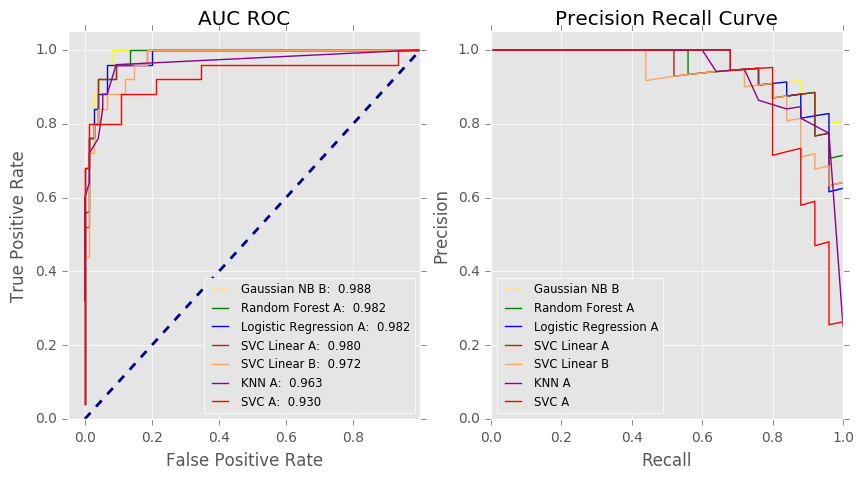

In [0]:
# Plot AUC-ROC and precision-recall curves for best models

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(10,5)

ax1.plot(roc_gnbb.FPR, roc_gnbb.TPR, color='yellow', lw=1, label= metrics_gnbb.columns.values.tolist()[0] + ':  %.3f' % metrics_gnbb.at['ROC AUC', metrics_gnbb.columns.values.tolist()[0]])
ax1.plot(roc_rfca.FPR, roc_rfca.TPR, color='green', lw=1, label= metrics_rfca.columns.values.tolist()[0] + ':  %.3f' % metrics_rfca.at['ROC AUC', metrics_rfca.columns.values.tolist()[0]])
ax1.plot(roc_lgra.FPR, roc_lgra.TPR, color='blue', lw=1, label= metrics_lgra.columns.values.tolist()[0] + ':  %.3f' % metrics_lgra.at['ROC AUC', metrics_lgra.columns.values.tolist()[0]])
ax1.plot(roc_svla.FPR, roc_svla.TPR, color='brown', lw=1, label= metrics_svla.columns.values.tolist()[0] + ':  %.3f' % metrics_svla.at['ROC AUC', metrics_svla.columns.values.tolist()[0]])
ax1.plot(roc_svlb.FPR, roc_svlb.TPR, color='sandybrown', lw=1, label= metrics_svlb.columns.values.tolist()[0] + ':  %.3f' % metrics_svlb.at['ROC AUC', metrics_svlb.columns.values.tolist()[0]])
ax1.plot(roc_knna.FPR, roc_knna.TPR, color='darkmagenta', lw=1, label= metrics_knna.columns.values.tolist()[0] + ':  %.3f' % metrics_knna.at['ROC AUC', metrics_knna.columns.values.tolist()[0]])
ax1.plot(roc_svca.FPR, roc_svca.TPR, color='red', lw=1, label= metrics_svca.columns.values.tolist()[0] + ':  %.3f' % metrics_svca.at['ROC AUC', metrics_svca.columns.values.tolist()[0]])
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize='small')
ax1.set_title('AUC ROC')

ax2.plot(prc_gnbb.Recall, prc_gnbb.Precision, color='yellow', lw=1, label= metrics_gnbb.columns.values.tolist()[0])
ax2.plot(prc_rfca.Recall, prc_rfca.Precision, color='green', lw=1, label= metrics_rfca.columns.values.tolist()[0])
ax2.plot(prc_lgra.Recall, prc_lgra.Precision, color='blue', lw=1, label= metrics_lgra.columns.values.tolist()[0])
ax2.plot(prc_svla.Recall, prc_svla.Precision, color='brown', lw=1, label= metrics_svla.columns.values.tolist()[0])
ax2.plot(prc_svlb.Recall, prc_svlb.Precision, color='sandybrown', lw=1, label= metrics_svlb.columns.values.tolist()[0])
ax2.plot(prc_knna.Recall, prc_knna.Precision, color='darkmagenta', lw=1, label= metrics_knna.columns.values.tolist()[0])
ax2.plot(prc_svca.Recall, prc_svca.Precision, color='red', lw=1, label= metrics_svca.columns.values.tolist()[0])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')
ax2.set_title('Precision Recall Curve')
        

## 이진 분류 성능 요약

* 특성을 추가하면 성능이 좋아진다.
* 랜덤 포레스트와 나이브 베이즈의 성능은 특성 추가 전후에 같다.
* 리콜점수는 Naive Bayes와 Linear SVC (with new features)의 성능이 좋다
* Linear SVC는 특성 추출 전후의 성능 변화가 크다
* SVC (rbf)의 AUC-ROC는 낮지만 precision-recall 특성은 좋다(threshold 0.17에서)

## 전체 기대치 계산
* TPR, FPR, Engines 그래프는 비용 매트릭스와 함께 (TP, FP, TN, FN) 계산하여 전체적인 기대치 및 손실값을 구하는데 사용된다.
- cost-benefit matrix와 confusion matrix를 같이 사용한다

In [0]:
# benefit과 cost 가정치
TPb = 300
TNb = 0
FPc = -100
FNc = -200

# 실제 데이터 분포
prob_positive = 0.25 
prop_negative = 0.75


In [0]:
# roc 데이터프레임을 사용하여 최대 이익을 계산

df_max_profit = pd.DataFrame()

roc_dfs = [roc_lgrb, roc_lgra, roc_dtrb, roc_dtra, roc_rfcb, roc_rfca, roc_svcb, roc_svca, roc_svlb, roc_svla, roc_knnb, roc_knna, roc_gnbb, roc_gnba]

for df in roc_dfs:
    df['Profit'] = prob_positive*(df.TPR*TPb + df.FNR*FNc) + prop_negative*(df.TNR*TNb + df.FPR*FPc)
    df_max = df[df.Profit == df.Profit.max()]
    df_max_profit = pd.concat([df_max_profit,df_max], ignore_index=True)
    
colnames = ['Profit', 'Model', 'Que', 'Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR', 'FNR']

# sort results by Profit
df_max_profit = df_max_profit[colnames].sort_values(by='Profit', ascending=False).reset_index(drop=True)
df_max_profit



Profit                  Model   Que  Threshold  TP  FP  TN  FN   TPR  \
0   19.000000          Gaussian NB B  0.31   0.090529  25   0  69   6  1.00   
1   18.694444  Logistic Regression B  0.28   0.111812  24   1  71   4  0.96   
2   18.694444          Gaussian NB A  0.28   0.969744  24   1  71   4  0.96   
3   17.704225  Logistic Regression A  0.29   0.063550  24   1  70   5  0.96   
4   17.351351        Random Forest A  0.26   0.179746  23   2  72   3  0.92   
5   17.351351           SVC Linear A  0.26   0.777863  23   2  72   3  0.92   
6   17.000000        Random Forest B  0.33   0.097536  25   0  67   8  1.00   
7   15.724638                  KNN A  0.31   0.076923  24   1  68   7  0.96   
8   13.054795           SVC Linear B  0.27  -0.594239  22   3  70   5  0.88   
9   12.164557                  SVC A  0.21  -0.227728  20   5  74   1  0.80   
10  12.083333                  SVC B  0.28  -0.935790  22   3  69   6  0.88   
11  10.702703                  KNN B  0.26   0.307692  21   4  70   5  0.84   
12  10.142857        Decision Tree A  0.30   0.180978  22   3  67   8  0.88   
13   7.816901        Decision Tree B  0.29   0.082857  21   4  67   8  0.84   

         FPR       TNR       FNR  
0   0.080000  0.920000  1.000000  
1   0.053333  0.946667  0.986111  
2   0.053333  0.946667  0.986111  
3   0.066667  0.933333  0.985915  
4   0.040000  0.960000  0.972973  
5   0.040000  0.960000  0.972973  
6   0.106667  0.893333  1.000000  
7   0.093333  0.906667  0.985507  
8   0.066667  0.933333  0.958904  
9   0.013333  0.986667  0.936709  
10  0.080000  0.920000  0.958333  
11  0.066667  0.933333  0.945946  
12  0.106667  0.893333  0.957143  
13  0.106667  0.893333  0.943662

- 가우시언 나이브 베이즈 알고리즘이 최대의 이익을 계산했다.(USD 19K per engine)
- %31의 엔진을 교체하는 경우

In [0]:
# sort the results by Que (capacity) and Profit

df_max_profit = df_max_profit[colnames].sort_values(by=['Que', 'Profit'], ascending=[True, False]).reset_index(drop=True)
df_max_profit


Profit                  Model   Que  Threshold  TP  FP  TN  FN   TPR  \
0   12.164557                  SVC A  0.21  -0.227728  20   5  74   1  0.80   
1   17.351351        Random Forest A  0.26   0.179746  23   2  72   3  0.92   
2   17.351351           SVC Linear A  0.26   0.777863  23   2  72   3  0.92   
3   10.702703                  KNN B  0.26   0.307692  21   4  70   5  0.84   
4   13.054795           SVC Linear B  0.27  -0.594239  22   3  70   5  0.88   
5   18.694444  Logistic Regression B  0.28   0.111812  24   1  71   4  0.96   
6   18.694444          Gaussian NB A  0.28   0.969744  24   1  71   4  0.96   
7   12.083333                  SVC B  0.28  -0.935790  22   3  69   6  0.88   
8   17.704225  Logistic Regression A  0.29   0.063550  24   1  70   5  0.96   
9    7.816901        Decision Tree B  0.29   0.082857  21   4  67   8  0.84   
10  10.142857        Decision Tree A  0.30   0.180978  22   3  67   8  0.88   
11  19.000000          Gaussian NB B  0.31   0.090529  25   0  69   6  1.00   
12  15.724638                  KNN A  0.31   0.076923  24   1  68   7  0.96   
13  17.000000        Random Forest B  0.33   0.097536  25   0  67   8  1.00   

         FPR       TNR       FNR  
0   0.013333  0.986667  0.936709  
1   0.040000  0.960000  0.972973  
2   0.040000  0.960000  0.972973  
3   0.066667  0.933333  0.945946  
4   0.066667  0.933333  0.958904  
5   0.053333  0.946667  0.986111  
6   0.053333  0.946667  0.986111  
7   0.080000  0.920000  0.958333  
8   0.066667  0.933333  0.985915  
9   0.106667  0.893333  0.943662  
10  0.106667  0.893333  0.957143  
11  0.080000  0.920000  1.000000  
12  0.093333  0.906667  0.985507  
13  0.106667  0.893333  1.000000

## 결과 해석

- Working at capacity of %26: 엔진당 최대 수익이 USD 17.35 (Random Forest A or SVC Linear A)
- Working at capacity of %28: 엔진당 최대 수익 USD 18.69 (Logistic Regression B or Gaussian NB A)
